<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>neural network architecture</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# tl;dr

In this notebook we will try to estimate the parameters of the **Burgers' equation** using a neural network. The equation is given by $$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

# setup

In [30]:
import os
import pprint
import functools
import tqdm

import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

In [31]:
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['text.usetex'] = True

experiment_name = "burgers_equation"

folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

# data

**medidas** <br/> `todo`

(101, 1)
(1, 256)
(256, 101)


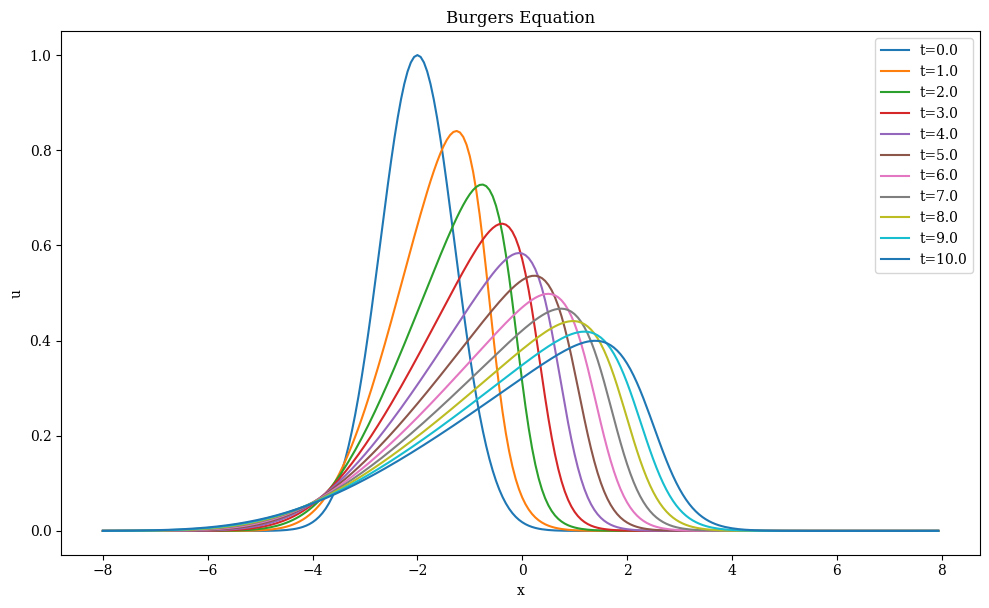

In [111]:
data = sio.loadmat('../data/01_raw/burgers.mat')
print(data["t"].shape)
print(data["x"].shape)
print(data["usol"].shape)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

for i in range(101):
    if i % 10 == 0:
        plt.plot(data["x"].flatten(), data["usol"][:, i].flatten(), label="t={}".format(data["t"].flatten()[i]))

plt.xlabel("x")
plt.ylabel("u")

plt.title("Burgers Equation")
plt.legend()
plt.tight_layout()

plt.savefig(f"{folder_path}/burgers_equation.png", dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


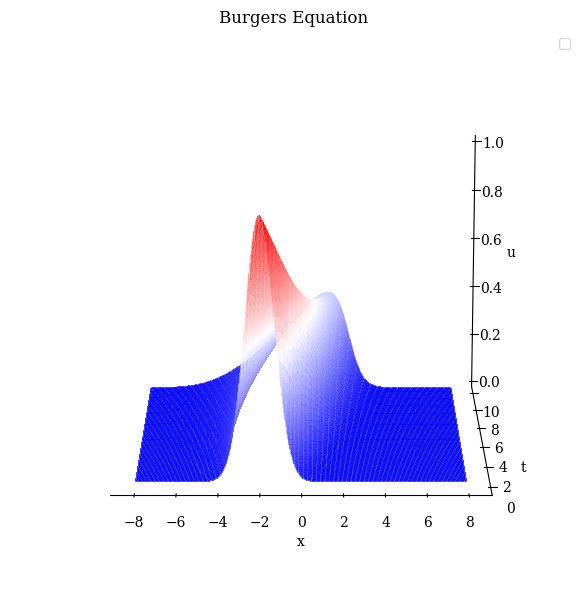

In [136]:
xx, tt = np.meshgrid(data["x"].flatten(), data["t"].flatten())

fig = plt.figure(figsize=(10, golden_ratio*10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    xx, tt, data["usol"].T, 
    cmap=plt.cm.bwr, linewidth=0, antialiased=False, rstride=1, cstride=1, alpha=0.5,
)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.view_init(15, -90)

plt.title("Burgers Equation")
plt.legend()
plt.tight_layout()

plt.savefig(f"{folder_path}/burgers_equation_3d.png", dpi=300)

In [57]:
torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# x_train = torch.tensor([(t, x) for t in data["t"] for x in data["x"]], dtype=torch.float32, device=device)
x_train = torch.tensor(np.hstack((xx.reshape(-1, 1), tt.reshape(-1, 1))), dtype=torch.float32, device=device)
y_train = torch.tensor(data["usol"].T, dtype=torch.float32, device=device).view(-1, 1)

# neural network architecture

In [58]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

In [59]:
hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 128,
    'num_epochs': 30000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

## training

$$\frac{\partial u}{\partial t} + \alpha u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0$$

In [98]:
hparam_dict = {
    'learning_rate': 1e-4,
    'n_layers': 4,
    'n_neurons': 64,
    'num_epochs': 20000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]
architecture = [2, 64, 64, 64, 64, 1]

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], param_=[])

space = np.linspace(0, 10, 10)
time = np.linspace(-8, 8, 10)
T, S = np.meshgrid(time, space)
T_flat = T.flatten()[:, None]
S_flat = S.flatten()[:, None]
location_points = np.hstack((S_flat, T_flat))
_locations = torch.tensor(location_points, dtype=torch.float32, device=device, requires_grad=True)

_alpha = torch.tensor(1.23, dtype=torch.float32, requires_grad=True, device=device)
_nu = torch.tensor(1.23, dtype=torch.float32, requires_grad=True, device=device)

model = MultiLayerPerceptronRegressor(architecture, nn.ELU)
model.to(device)

optimizer = optim.Adam([{"params": model.parameters()}, {"params": _alpha}, {"params": _nu}], lr=learning_rate)
criterion = nn.MSELoss()
loss = torch.tensor(1e6, dtype=torch.float, requires_grad=False).to(device)

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], param_alpha=[], param_nu=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    # if loss.item() > 1e-10 or epoch < 10000:
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        y_location_hat = model(_locations)
        
        dydx = torch.autograd.grad(y_location_hat.sum(), _locations, create_graph=True)[0][:, 0:1]
        dydt = torch.autograd.grad(y_location_hat.sum(), _locations, create_graph=True)[0][:, 1:2]
        dydxdydx = torch.autograd.grad(dydx.sum(), _locations, create_graph=True)[0][:, 0:1]

        if epoch > 1:
            _diff_equation = dydt + _alpha * y_location_hat * dydx - _nu * dydxdydx
            physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))
        else:
            physics_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)

        loss = data_loss + (1e-0)*(physics_loss)
        
        # backward
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            str_epoch = str(epoch+1).zfill(5)
            str_num_epochs = str(num_epochs).zfill(5)
            str_loss = str(round(loss.item(), 4))
            str_physics_loss = str(round(physics_loss.item(), 4))
            # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
            # print("F0: ", _F0.item())
            print("alpha: ", _alpha.item())
            print("nu: ", _nu.item())
            print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, Total Loss: {loss.item():.6f}")

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(physics_loss.item())
            plot_loss_train["param_alpha"].append(_alpha.item())
            plot_loss_train["param_nu"].append(_nu.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


  5%|▌         | 1032/20000 [00:05<01:50, 171.45it/s]

alpha:  1.2722246646881104
nu:  1.0905228853225708
Data Loss: 0.002836, Physics Loss: 0.001103, Total Loss: 0.003939


 10%|█         | 2022/20000 [00:11<01:46, 168.83it/s]

alpha:  1.155065894126892
nu:  0.9905357360839844
Data Loss: 0.001625, Physics Loss: 0.000724, Total Loss: 0.002349


 15%|█▌        | 3034/20000 [00:17<01:40, 168.98it/s]

alpha:  1.082061767578125
nu:  0.899761438369751
Data Loss: 0.001127, Physics Loss: 0.000494, Total Loss: 0.001622


 20%|██        | 4035/20000 [00:23<01:23, 192.04it/s]

alpha:  1.0322747230529785
nu:  0.8183037638664246
Data Loss: 0.000871, Physics Loss: 0.000338, Total Loss: 0.001210


 25%|██▌       | 5015/20000 [00:29<01:37, 153.06it/s]

alpha:  1.0641335248947144
nu:  0.7264744639396667
Data Loss: 0.000839, Physics Loss: 0.000319, Total Loss: 0.001158


 30%|███       | 6019/20000 [00:34<01:23, 167.40it/s]

alpha:  1.1133064031600952
nu:  0.6332384347915649
Data Loss: 0.000569, Physics Loss: 0.000266, Total Loss: 0.000835


 35%|███▌      | 7029/20000 [00:40<01:05, 196.94it/s]

alpha:  1.1124327182769775
nu:  0.5520526766777039
Data Loss: 0.000381, Physics Loss: 0.000189, Total Loss: 0.000570


 40%|████      | 8034/20000 [00:45<01:02, 192.52it/s]

alpha:  1.0601592063903809
nu:  0.46503332257270813
Data Loss: 0.000324, Physics Loss: 0.000149, Total Loss: 0.000474


 45%|████▌     | 9025/20000 [00:50<00:58, 188.61it/s]

alpha:  1.0968164205551147
nu:  0.37303999066352844
Data Loss: 0.000245, Physics Loss: 0.000102, Total Loss: 0.000347


 50%|█████     | 10037/20000 [00:56<00:52, 189.16it/s]

alpha:  1.1510456800460815
nu:  0.2900809347629547
Data Loss: 0.000135, Physics Loss: 0.000061, Total Loss: 0.000197


 55%|█████▌    | 11024/20000 [01:02<00:52, 172.38it/s]

alpha:  1.1425014734268188
nu:  0.22081728279590607
Data Loss: 0.000072, Physics Loss: 0.000026, Total Loss: 0.000098


 60%|██████    | 12030/20000 [01:08<00:48, 166.04it/s]

alpha:  1.086863398551941
nu:  0.16740800440311432
Data Loss: 0.000039, Physics Loss: 0.000017, Total Loss: 0.000055


 65%|██████▌   | 13039/20000 [01:13<00:36, 191.85it/s]

alpha:  1.0298254489898682
nu:  0.13122257590293884
Data Loss: 0.000022, Physics Loss: 0.000008, Total Loss: 0.000030


 70%|███████   | 14025/20000 [01:19<00:31, 187.50it/s]

alpha:  1.001896619796753
nu:  0.11699822545051575
Data Loss: 0.000021, Physics Loss: 0.000004, Total Loss: 0.000024


 75%|███████▌  | 15033/20000 [01:24<00:25, 195.25it/s]

alpha:  0.9950900077819824
nu:  0.11194101721048355
Data Loss: 0.000022, Physics Loss: 0.000003, Total Loss: 0.000025


 80%|████████  | 16039/20000 [01:29<00:19, 198.71it/s]

alpha:  0.9889183044433594
nu:  0.10902795195579529
Data Loss: 0.000008, Physics Loss: 0.000002, Total Loss: 0.000010


 85%|████████▌ | 17029/20000 [01:34<00:15, 197.14it/s]

alpha:  0.9891337156295776
nu:  0.10844369232654572
Data Loss: 0.000007, Physics Loss: 0.000001, Total Loss: 0.000008


 90%|█████████ | 18030/20000 [01:39<00:09, 203.54it/s]

alpha:  0.9858373403549194
nu:  0.10645272582769394
Data Loss: 0.000006, Physics Loss: 0.000001, Total Loss: 0.000007


 95%|█████████▌| 19024/20000 [01:45<00:05, 189.80it/s]

alpha:  0.9830323457717896
nu:  0.1055021584033966
Data Loss: 0.000005, Physics Loss: 0.000001, Total Loss: 0.000006


100%|██████████| 20000/20000 [01:50<00:00, 181.20it/s]

alpha:  0.9927868843078613
nu:  0.10393279045820236
Data Loss: 0.000006, Physics Loss: 0.000001, Total Loss: 0.000007


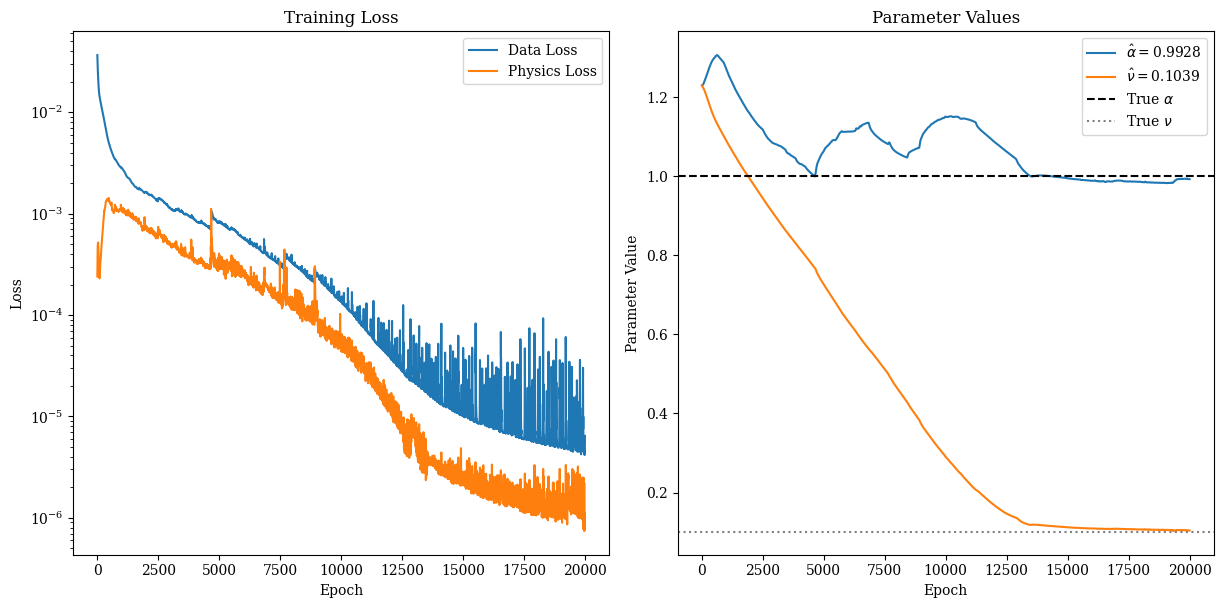

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(2*golden_ratio*10, golden_ratio*10))

ax1.plot(plot_loss_train["epoch"], plot_loss_train["dataloss"], label="Data Loss")
ax1.plot(plot_loss_train["epoch"], plot_loss_train["physicsloss"], label="Physics Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()
ax1.set_yscale("log")

ax2.plot(plot_loss_train["epoch"], plot_loss_train["param_alpha"], label=r"$\hat{\alpha}=$" + str(round(_alpha.item(), 4)))
ax2.plot(plot_loss_train["epoch"], plot_loss_train["param_nu"], label=r"$\hat{\nu}=$" + str(round(_nu.item(), 4)))

ax2.axhline(y=1.0, color="black", linestyle="--", label=r"True $\alpha$")
ax2.axhline(y=0.1, color="gray", linestyle=":", label=r"True $\nu$")

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Parameter Value")
ax2.set_title("Parameter Values")
ax2.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

## results

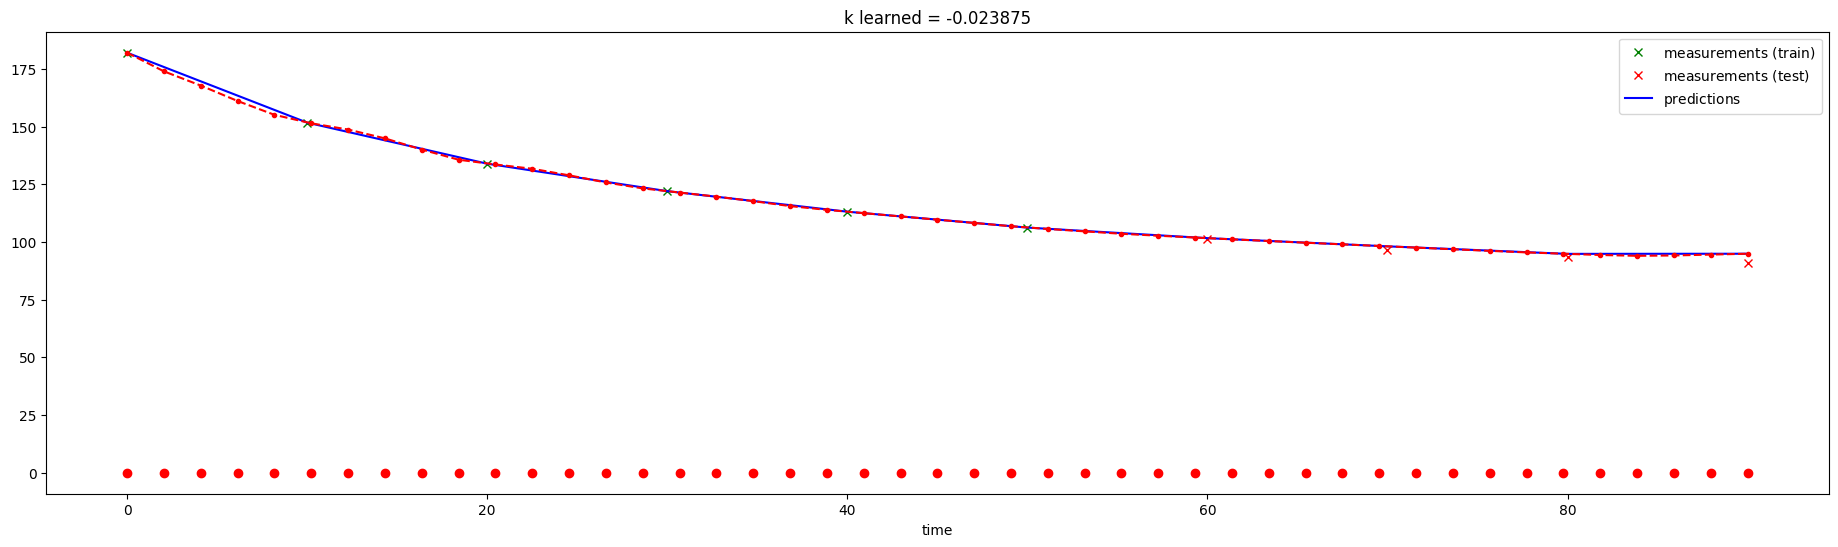

In [12]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

plt.title(f"k learned = {_k.item():.6f}") ;

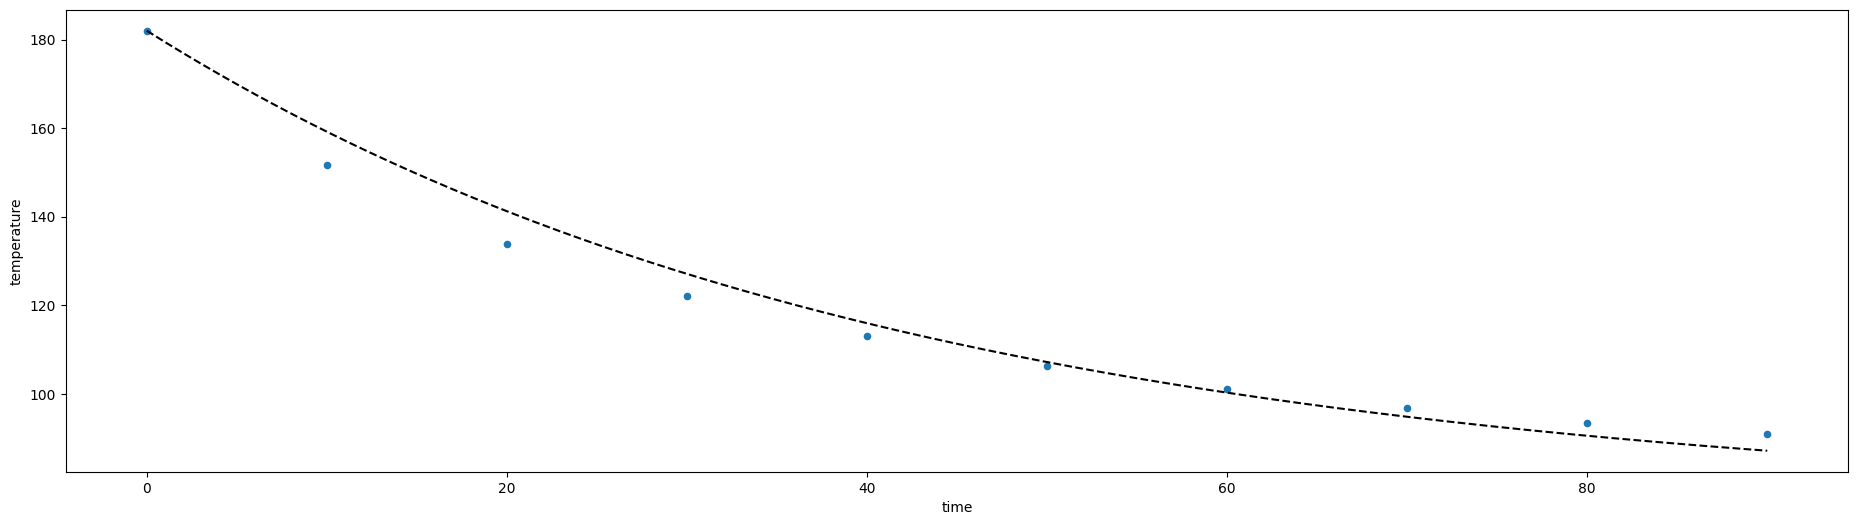

In [13]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.plot.scatter(x='time', y='temperature', ax=ax1)

t = np.linspace(0, 90, 1000)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S

ax1.plot(
    t,
    T, 
    c="k", linestyle="--",
    label="Theoretical model"
) ;

.